## Regional-average SST Skill (correlation & RMSE)

In [1]:
%load_ext autoreload
%autoreload 2
import xarray as xr 
import numpy as np  
import cftime
import copy
import scipy.stats
from scipy import signal
from functools import partial
import glob
import dask
import matplotlib.pyplot as plt
%matplotlib inline

# SMYLE Utility functions
from SMYLEutils import calendar_utils as cal
from SMYLEutils import stat_utils as stat
from SMYLEutils import mapplot_utils as maps
from SMYLEutils import colorbar_utils as cbars
from SMYLEutils import io_utils as io

## Create Dask Cluster

In [ ]:
# Close out Dask Cluster and release workers:
# NOTE:  only run this cell to terminate Dask Cluster!
cluster.close()
client.close()

In [2]:
def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=1,
        memory='20GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=1:mem=20GB',
        project='P54048000',
        walltime='02:00:00',
        interface='ib0',)

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status',
        'array.slicing.split_large_chunks':True
    })
    client = Client(cluster)
    return cluster, client

In [3]:
cluster, client = get_ClusterClient()
cluster.scale(30) 

In [4]:
cluster

# Data Intake

### Read in POP monthly SST field using I/O functions; Convert to seasonal mean

In [4]:
# This preprocessor will return POP SST (first vertical grid level only)
def preprocessor(d0,nlead,field):
    """ This preprocessor is applied on an individual timeseries file basis. Edit this appropriately
    for your analysis to speed up processing. 
    
    Here,
        - reset monthly time to mid-month value
        - select top vertical level and only nlead time values
        - drop fields unrelated to SST
    """
    d0 = cal.time_set_midmonth(d0,'time')
    d0 = d0.isel(z_t=0).isel(time=slice(0, nlead))
    d0 = d0.assign_coords(L=("time", np.arange(d0.sizes["time"])+1))
    d0 = d0.swap_dims({"time": "L"})
    d0 = d0.reset_coords(["time"])
    d0["time"] = d0.time.expand_dims("Y")
    d0 = d0[[field,'time','TLAT','TLONG','TAREA']].drop(['ULAT','ULONG'])
    d0 = d0.chunk({'L':-1})
    return d0

In [5]:
%%time
# SMYLE-Nov SST data
# process all 20 ensemble members, all November start dates from 1970-2018:
field = 'TEMP'
datadir = '/glade/campaign/cesm/development/espwg/SMYLE/archive/'
casename = 'b.e21.BSMYLE.f09_g17.????-MM.EEE'
filetype = '.pop.h.'
filetemplate = datadir+casename+'/ocn/proc/tseries/month_1/'+casename+filetype+field+'.*.nc'
ens = 20 
nlead = 24
firstyear = 1970
lastyear  = 2018
startmonth = 11
#chunks={'z_t':1,'nlat':80}
smyle11 = io.get_monthly_data(filetemplate,filetype,ens,nlead,field,firstyear,lastyear,startmonth,preprocessor)
smyle11.nbytes/1e9 #GB

CPU times: user 20.9 s, sys: 10.2 s, total: 31.1 s
Wall time: 39.4 s


11.563509676

In [6]:
%%time
smyle11_seas = cal.mon_to_seas_dask(smyle11).persist()

CPU times: user 11.8 s, sys: 173 ms, total: 12 s
Wall time: 12.5 s


In [7]:
%%time
# SMYLE-Feb SST data
# process all 20 ensemble members, all February start dates from 1970-2018:
field = 'TEMP'
datadir = '/glade/campaign/cesm/development/espwg/SMYLE/archive/'
casename = 'b.e21.BSMYLE.f09_g17.????-MM.EEE'
filetype = '.pop.h.'
filetemplate = datadir+casename+'/ocn/proc/tseries/month_1/'+casename+filetype+field+'.*.nc'
ens = 20 
nlead = 24
firstyear = 1970
lastyear  = 2018
startmonth = 2
#chunks={'z_t':1,'nlat':80}
smyle02 = io.get_monthly_data(filetemplate,filetype,ens,nlead,field,firstyear,lastyear,startmonth,preprocessor)
smyle02.nbytes/1e9 #GB

CPU times: user 48.7 s, sys: 11 s, total: 59.7 s
Wall time: 1min 28s


11.563509676

In [8]:
smyle02_seas = cal.mon_to_seas_dask(smyle02).persist()

In [9]:
%%time
# SMYLE-May SST data
# process all 20 ensemble members, all May start dates from 1970-2018:
field = 'TEMP'
datadir = '/glade/campaign/cesm/development/espwg/SMYLE/archive/'
casename = 'b.e21.BSMYLE.f09_g17.????-MM.EEE'
filetype = '.pop.h.'
filetemplate = datadir+casename+'/ocn/proc/tseries/month_1/'+casename+filetype+field+'.*.nc'
ens = 20 
nlead = 24
firstyear = 1970
lastyear  = 2018
startmonth = 5
#chunks={'z_t':1,'nlat':80}
smyle05 = io.get_monthly_data(filetemplate,filetype,ens,nlead,field,firstyear,lastyear,startmonth,preprocessor)
smyle05.nbytes/1e9 #GB

CPU times: user 49.9 s, sys: 11 s, total: 1min
Wall time: 1min 28s


11.563509676

In [10]:
smyle05_seas = cal.mon_to_seas_dask(smyle05).persist()

In [11]:
%%time
# SMYLE-Aug SST data
# process all 20 ensemble members, all August start dates from 1970-2018:
field = 'TEMP'
datadir = '/glade/campaign/cesm/development/espwg/SMYLE/archive/'
casename = 'b.e21.BSMYLE.f09_g17.????-MM.EEE'
filetype = '.pop.h.'
filetemplate = datadir+casename+'/ocn/proc/tseries/month_1/'+casename+filetype+field+'.*.nc'
ens = 20 
nlead = 24
firstyear = 1970
lastyear  = 2018
startmonth = 8
#chunks={'z_t':1,'nlat':80}
smyle08 = io.get_monthly_data(filetemplate,filetype,ens,nlead,field,firstyear,lastyear,startmonth,preprocessor)
smyle08.nbytes/1e9 #GB

CPU times: user 51.5 s, sys: 11.2 s, total: 1min 2s
Wall time: 1min 30s


11.563509676

In [12]:
smyle08_seas = cal.mon_to_seas_dask(smyle08).persist()

In [ ]:
#smyle02_2mon = smyle02.rolling(dim='L',time=2, center=True).mean()
#smyle02_seas[:,:,{'L'=24},:,:] = smyle02.sel(L=slice(23,24)).mean('L') #replace the missing DJF(2) value with DJ value
#smyle02_seas.TEMP.sel(L=24).values=smyle02.TEMP.sel(L=slice(23,24)).mean('L').values
#smyle02_seas = smyle02_seas.where((smyle02_seas['L'] == 24),smyle02.TEMP.sel(L=slice(23,24)).mean('L'))
#print(smyle02.sel(L=23).isel(M=1).isel(Y=3).isel(nlat=89).values)
#smyle02_seas
#smyle02_seas.sel(L=24).update({"L": ("L", smyle02.sel(L=slice(23,24)).mean('L'))})
#print(smyle02.TEMP.sel(L=slice(23,24)).mean('L').isel(M=1).isel(Y=3).isel(nlat=89).values)
#print(smyle02.TEMP.sel(L=24).isel(M=1).isel(Y=3).isel(nlat=89).values)
#print(smyle02.TEMP.sel(L=23).isel(M=1).isel(Y=3).isel(nlat=89).values)

In [13]:
smyle02_rolling = smyle02.rolling(L=2, center=True).mean()
smyle02_seas = xr.concat([smyle02_seas.sel(L=slice(3,21)),smyle02_rolling.sel(L=24)],dim='L') #replace the missing DJF(2) value with DJ value
#print(smyle02_seas.TEMP.isel(L=7).isel(M=1).isel(Y=3).isel(nlat=89).values)

In [14]:
%%time
smyle02_seas.persist()

CPU times: user 5.73 s, sys: 84.7 ms, total: 5.81 s
Wall time: 5.93 s


<xarray.Dataset>
Dimensions:  (nlat: 384, nlon: 320, L: 8, Y: 49, M: 20)
Coordinates:
    TLAT     (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 72.2 72.19 72.19
    TLONG    (nlat, nlon) float64 320.6 321.7 322.8 323.9 ... 318.9 319.4 319.8
    z_t      float32 500.0
  * L        (L) int64 3 6 9 12 15 18 21 24
  * Y        (Y) int64 1970 1971 1972 1973 1974 ... 2014 2015 2016 2017 2018
  * M        (M) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20
Dimensions without coordinates: nlat, nlon
Data variables:
    TEMP     (Y, L, M, nlat, nlon) float64 dask.array<chunksize=(1, 1, 1, 384, 320), meta=np.ndarray>
    TAREA    (L, nlat, nlon) float64 dask.array<chunksize=(7, 384, 320), meta=np.ndarray>
    time     (Y, L) object dask.array<chunksize=(1, 7), meta=np.ndarray>
Attributes:
    title:             b.e21.BSMYLE.f09_g17.1970-02.001
    history:           none
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
    source:            CCSM POP2, the CCSM Ocean Component
    revision:          $Id$
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2021-04-07 at 14:42:32.7
    cell_methods:      cell_methods = time: mean ==> the variable values are ...

In [15]:
smyle02_seas['time'] = smyle02['time']
smyle02_seas['TAREA'] = smyle02['TAREA']
smyle02_seas

<xarray.Dataset>
Dimensions:  (L: 8, nlat: 384, nlon: 320, Y: 49, M: 20)
Coordinates:
  * L        (L) int64 3 6 9 12 15 18 21 24
    TLAT     (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 72.2 72.19 72.19
    TLONG    (nlat, nlon) float64 320.6 321.7 322.8 323.9 ... 318.9 319.4 319.8
    z_t      float32 500.0
  * Y        (Y) int64 1970 1971 1972 1973 1974 ... 2014 2015 2016 2017 2018
  * M        (M) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20
Dimensions without coordinates: nlat, nlon
Data variables:
    TEMP     (Y, L, M, nlat, nlon) float64 dask.array<chunksize=(1, 1, 1, 384, 320), meta=np.ndarray>
    TAREA    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    time     (Y, L) object dask.array<chunksize=(1, 8), meta=np.ndarray>
Attributes:
    title:             b.e21.BSMYLE.f09_g17.1970-02.001
    history:           none
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
    source:            CCSM POP2, the CCSM Ocean Component
    revision:          $Id$
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2021-04-07 at 14:42:32.7
    cell_methods:      cell_methods = time: mean ==> the variable values are ...

# Compute Regional-average SST

### Define Averaging Region

In [16]:
#lon-w, lon-e, lat-s, lat-n:
regionlonlat = [-170.,-120.,-5.,5.]  
regiontitle = 'Nino3.4'

#regionlonlat = [-20.,0.,-3.,3.]  
#regiontitle = 'Atlantic Nino'

#regionlonlat = [-80.,-10.,10.,20.]  
#regiontitle = 'Atlantic MDR'

#regionlonlat = [50.,70.,-10.,10.]    # IOD-west, to be overwritten by IOD
#regiontitle = 'Indian Ocean Dipole'

#regionlonlat = [90.,110.,-10.,0.]  # IOD-east
#regiontitle = 'IODe'

In [17]:
def POP_regional_areawgt(ds,lonlat):
    tarea = ds.TAREA
    tlat = ds.TLAT
    tlon = xr.where(ds.TLONG>180.,ds.TLONG-360.,ds.TLONG)
    region = (tlat>=lonlat[2]) & (tlat<=lonlat[3]) & (tlon>=lonlat[0]) & (tlon<=lonlat[1])
    return xr.where(region,tarea.fillna(0),0)

In [18]:
POPg16_regsst_area = POP_regional_areawgt(smyle11,regionlonlat)

### Perform computation on SMYLE, returning xarray:

In [19]:
%%time
smyle11_seas_time = smyle11_seas.time.load()
smyle02_seas_time = smyle02_seas.time.load()
smyle05_seas_time = smyle05_seas.time.load()
smyle08_seas_time = smyle08_seas.time.load()

CPU times: user 11.7 s, sys: 371 ms, total: 12.1 s
Wall time: 1min 3s


In [20]:
%%time
smyle11_seas_regsst = smyle11_seas.TEMP.weighted(POPg16_regsst_area).mean(("nlon", "nlat")).load()
smyle02_seas_regsst = smyle02_seas.TEMP.weighted(POPg16_regsst_area).mean(("nlon", "nlat")).load()
smyle05_seas_regsst = smyle05_seas.TEMP.weighted(POPg16_regsst_area).mean(("nlon", "nlat")).load()
smyle08_seas_regsst = smyle08_seas.TEMP.weighted(POPg16_regsst_area).mean(("nlon", "nlat")).load()

CPU times: user 1min 43s, sys: 1.31 s, total: 1min 45s
Wall time: 1min 48s


### Remove leadtime-dependent drift from SMYLE data:

In [21]:
%%time
# Remove leadtime-dependent drift
climy0 = 1972
climy1 = 2018
smyle11_regsst_dd,smyle11_regsst_drift = stat.remove_drift(smyle11_seas_regsst,smyle11_seas_time,climy0,climy1)
smyle02_regsst_dd,smyle02_regsst_drift = stat.remove_drift(smyle02_seas_regsst,smyle02_seas_time,climy0,climy1)
smyle05_regsst_dd,smyle05_regsst_drift = stat.remove_drift(smyle05_seas_regsst,smyle05_seas_time,climy0,climy1)
smyle08_regsst_dd,smyle08_regsst_drift = stat.remove_drift(smyle08_seas_regsst,smyle08_seas_time,climy0,climy1)

CPU times: user 10.4 ms, sys: 933 µs, total: 11.3 ms
Wall time: 11.3 ms


### Compute observed seasonal anomalies:

In [22]:
def obs_convert_mon_to_seas(da,field):
    """ Given a monthly xarray DataArray, convert to 
    seasonal averages and replace 'time' with 'year,season' dimensions."""
    season = xr.DataArray(['DJF','MAM','JJA','SON'],dims='season',name='season')
    da_group = cal.mon_to_seas(da).groupby('time.month')
    xrlist = []
    for i in [1,4,7,10]:
        tmp = da_group[i]
        tmp = tmp.assign_coords(year=("time", np.unique(tmp.time.dt.year.values)))
        tmp = tmp.swap_dims({"time": "year"}).to_dataset(name=field)
        tmp = tmp.reset_coords(["time"])
        tmp["time"] = tmp.time.expand_dims("season")
        xrlist.append(tmp)
    da_seas = xr.concat(xrlist,dim=season)
    return da_seas

In [23]:
# Observed SST Index (NOAA ERSSTv5)
#ds_obs = xr.open_dataset('/glade/campaign/cesm/development/espwg/verification_datasets/mon/SST/ersst.v5.188001-202012.nc',decode_times=False)
#obs_time_vals = [cftime.DatetimeNoLeap(1880+year, 1+month, 15) for year in range(141) for month in range(12)]
#ds_obs['time'] = obs_time_vals
#obs_sst_tmp = ds_obs.sst.sel(lat=slice(regionlonlat[2],regionlonlat[3])).sel(lon=slice(360+regionlonlat[0],360+regionlonlat[1]))
#obs_wgts = np.cos(np.deg2rad(obs_sst_tmp.lat))
#obs_regsst = obs_sst_tmp.weighted(obs_wgts).mean(("lon", "lat")).load()

# HADISST  (1deg SST over ocean)
obs_dir = '/glade/work/xianwu/data/obs/'
ds_obs = xr.open_dataset(obs_dir+'hadisst/HadISST_sst.nc').sel(time=slice("1870","2021"))
nt = np.size(ds_obs.time)
obs_montime_vals = [cftime.DatetimeNoLeap(1870+year-1, 1+month, 15) for year in range(152) for month in range(12)]   ##shift the year -1 to match D (the year) JF
ds_obs['time'] = obs_montime_vals
ds_obs['sst'] = xr.where(ds_obs['sst']<-2,-1.8,ds_obs['sst'])
ds_obs = ds_obs.sel(time=slice("1969","2021"))

# Note that latitude decreases with index in this dataset!
ds_obs = ds_obs.rename({"latitude":"lat","longitude":"lon"})

In [24]:
# Region
tmp = ds_obs.sst.sel(lat=slice(regionlonlat[3],regionlonlat[2])).sel(lon=slice(regionlonlat[0],regionlonlat[1]))
wgts = np.cos(np.deg2rad(tmp.lat))
obs_regsst = tmp.weighted(wgts).mean(("lon", "lat")).load()
obs_regsst_seas = obs_convert_mon_to_seas(obs_regsst,'sst')
obs_regsst_seas = obs_regsst_seas - obs_regsst_seas.sel(year=slice(climy0,climy1)).mean('year')

obs_regsst_rolling = obs_regsst.rolling(time=2, center=True).mean()
obs_regsst_rolling['time'] = obs_regsst['time']
mon = obs_regsst.time.dt.month.values
time = obs_regsst.time
timekeep = time.where((mon == 1)).dropna('time') #DJ
obs_regsst_seas_dj = obs_regsst_rolling.sel(time=timekeep)
obs_regsst_seas_dj = obs_regsst_seas_dj - obs_regsst_seas_dj.isel(time=slice(climy0-firstyear,climy1-firstyear)).mean('time')

<xarray.DataArray 'Y' (Y: 52)>
array([1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980,
       1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992,
       1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004,
       2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
       2017, 2018, 2019, 2020])
Coordinates:
  * Y        (Y) int64 1969 1970 1971 1972 1973 ... 2016 2017 2018 2019 2020

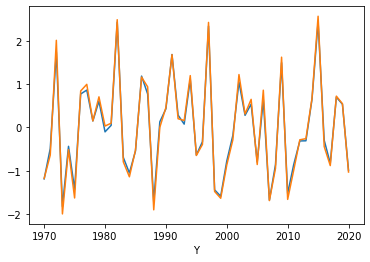

In [25]:
obs_regsst_seas_djf = obs_regsst_seas.isel(season=0)
obs_regsst_seas_djf = obs_regsst_seas_djf.rename({'year': 'Y'})
obs_regsst_seas_djf_detrend = stat.detrend_linear(obs_regsst_seas_djf.sst,'Y')

obs_regsst_seas_dj = obs_regsst_seas_dj.rename({'time': 'Y'})
obs_regsst_seas_dj_detrend = stat.detrend_linear(obs_regsst_seas_dj,'Y')
obs_regsst_seas_dj_detrend['Y'] = obs_regsst_seas_djf_detrend['Y'].isel(Y=slice(0,52)).values

obs_regsst_seas_djf_detrend.plot()
obs_regsst_seas_dj_detrend.plot()
obs_regsst_seas_dj_detrend.Y

In [26]:
smyle_djf1 = smyle11_regsst_dd.isel(L=0)
smyle_djf4 = smyle08_regsst_dd.isel(L=1)
smyle_djf7 = smyle05_regsst_dd.isel(L=2)
smyle_djf10 = smyle02_regsst_dd.isel(L=3)

smyle_djf13 = smyle11_regsst_dd.isel(L=4)
smyle_djf16 = smyle08_regsst_dd.isel(L=5)
smyle_djf19 = smyle05_regsst_dd.isel(L=6)
smyle_djf22 = smyle02_regsst_dd.isel(L=7)

smyle_djf13 = smyle_djf13.shift(Y=1)
smyle_djf16 = smyle_djf16.shift(Y=1)
smyle_djf19 = smyle_djf19.shift(Y=1)
smyle_djf22 = smyle_djf22.shift(Y=1)

In [27]:
# combine timeseries xarrays for plotting
startmonth= xr.DataArray([11,2,5,8],name='startmonth',dims='startmonth')
reg_ave = xr.concat([smyle_djf1,smyle_djf4,smyle_djf7,smyle_djf10,smyle_djf13,smyle_djf16,smyle_djf19,smyle_djf22],"dim")
reg_ave_ensmean_detrend = stat.detrend_linear(reg_ave.mean('M'),'Y')
reg_ave_ensmean_trend = stat.linear_trend(reg_ave.mean('M'),'Y')
reg_ave_detrend = reg_ave-reg_ave_ensmean_trend

In [28]:
import xskillscore as xs
ACC = xs.pearson_r(obs_regsst_seas_djf_detrend.sel(Y=slice('1970','2018')),reg_ave_ensmean_detrend.sel(Y=slice('1970','2018')),dim='Y',skipna=True)
nRMSE = xs.rmse(obs_regsst_seas_djf_detrend.sel(Y=slice('1970','2018')),reg_ave_ensmean_detrend.sel(Y=slice('1970','2018')),dim='Y',skipna=True)/obs_regsst_seas_djf_detrend.sel(Y=slice('1970','2018')).std('Y')
ACC2 = xs.pearson_r(obs_regsst_seas_dj_detrend.sel(Y=slice('1970','2018')),reg_ave_ensmean_detrend.sel(Y=slice('1970','2018')),dim='Y',skipna=True)
nRMSE2 = xs.rmse(obs_regsst_seas_dj_detrend.sel(Y=slice('1970','2018')),reg_ave_ensmean_detrend.sel(Y=slice('1970','2018')),dim='Y',skipna=True)/obs_regsst_seas_dj_detrend.sel(Y=slice('1970','2018')).std('Y')

In [29]:
ACC = ACC.to_numpy()
nRMSE = nRMSE.to_numpy()
ACC2 = ACC2.to_numpy()
nRMSE2 = nRMSE2.to_numpy()
print(ACC[7])
print(ACC2[7])
ACC[7] = ACC2[7]
nRMSE[7] = nRMSE2[7]
print(ACC[7])

0.3470133329897161
0.3495679488648609
0.3495679488648609


# Plots

### Timeseries

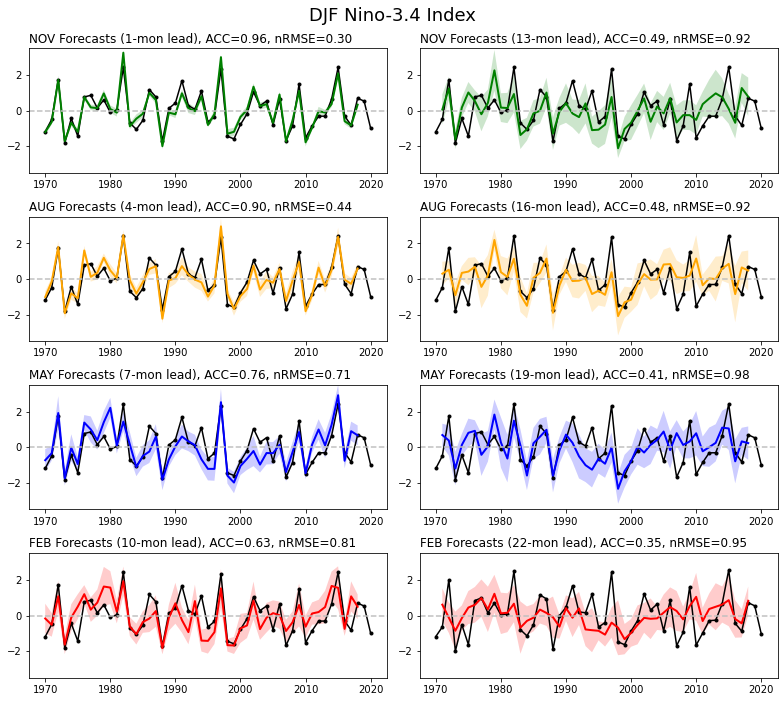

In [30]:
import matplotlib.patches as mpatches
fig = plt.figure(figsize=(10*1.1,9*1.1))

nrow=4
ncol=2
plt.rcParams.update({'font.size': 10})
hindcasts = ['NOV','AUG','MAY','FEB']
leadtime = ['1','4','7','10','13','16','19','22']
colors = ['g','orange','b','r']
for j in range(ncol):
    for i in range(nrow):
        ax = fig.add_subplot(nrow,ncol,i*2+1+j)
        ax.set_ylim([-3.5,3.5])
        if ((i+j*4) != 7):
            ax.plot(obs_regsst_seas_djf.Y,obs_regsst_seas_djf_detrend,color='k',marker='.',markersize=6)
        else:
            ax.plot(obs_regsst_seas_dj_detrend.Y,obs_regsst_seas_dj_detrend,color='k',marker='.',markersize=6)
        
        ax.set_title(hindcasts[i]+' Forecasts ('+leadtime[i+j*4]+'-mon lead), ACC='+'{0:3.2f}'.format(ACC[i+j*4])+', nRMSE='+'{0:3.2f}'.format(nRMSE[i+j*4]), loc='left')
        ax.plot(reg_ave.Y,reg_ave_ensmean_detrend.isel(dim=i+j*4),color=colors[i],linewidth=2)
        ymin = reg_ave_ensmean_detrend.isel(dim=i+j*4)-reg_ave_detrend.isel(dim=i+j*4).std('M')
        ymax = reg_ave_ensmean_detrend.isel(dim=i+j*4)+reg_ave_detrend.isel(dim=i+j*4).std('M')
        ax.fill_between(reg_ave_ensmean_detrend.Y,ymin,ymax,fc=colors[i],alpha=0.2)
        ax.axhline(y=0, color="silver", linestyle="--")
fig.suptitle('DJF Nino-3.4 Index',fontsize=18)
fig.tight_layout()
plt.savefig('Fig04_timeseries_Nino3.4_DJF.pdf')